### Libraries 📚⬇

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# import segmentation_models_pytorch as smp
# import segmentation_models_pytorch.utils.metrics

!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

### Defining train / val / test directories 📁

In [3]:
DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
#     print(semantic_map)
#     print(semantic_map.shape)
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
#     print(x)
#     print(x.shape)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

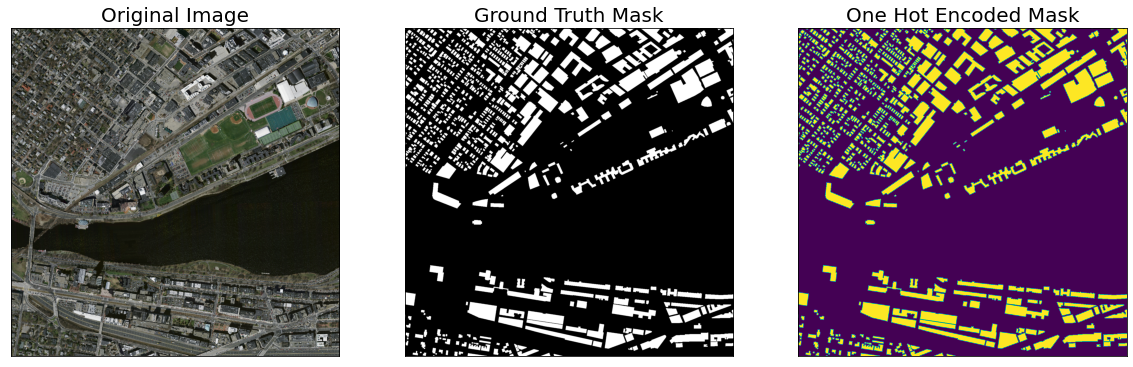

In [8]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[56]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [9]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

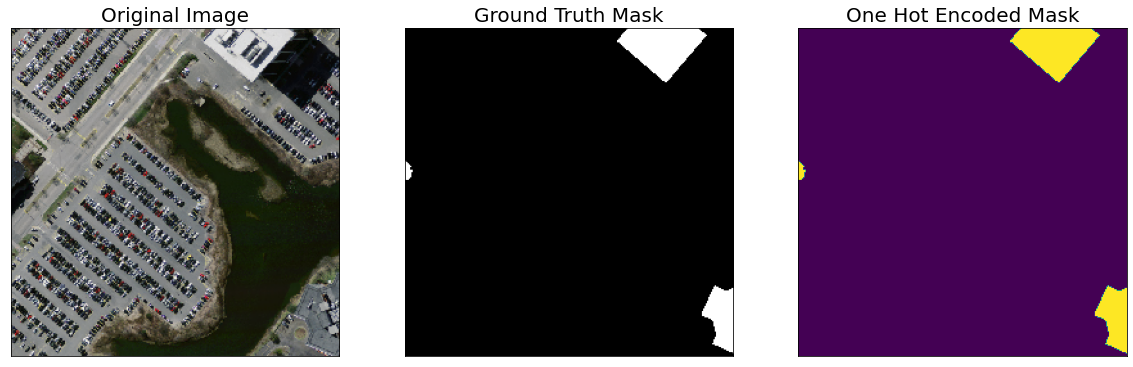

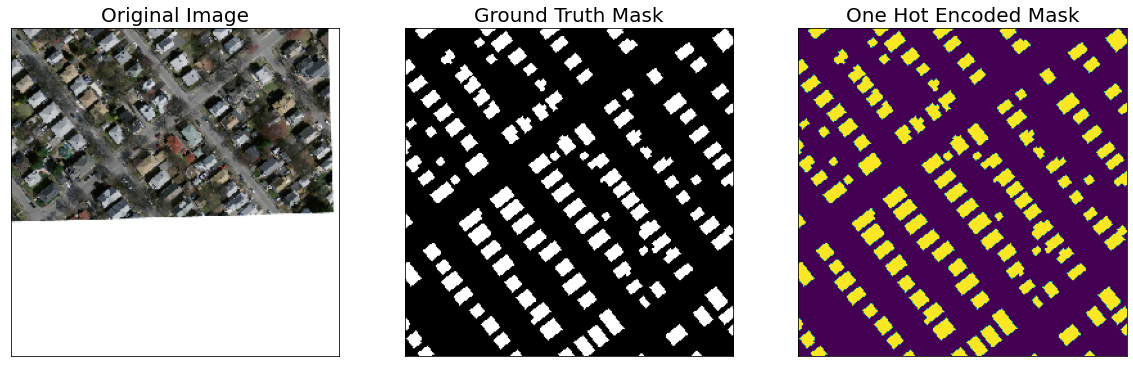

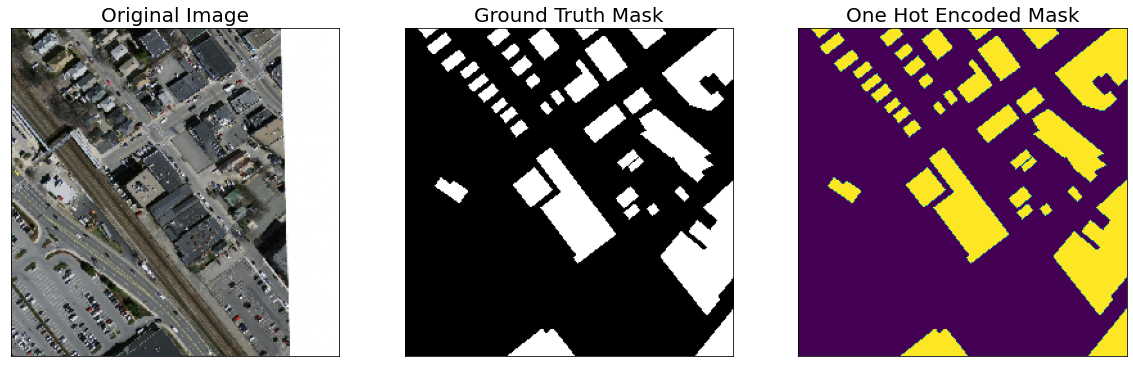

In [10]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet with Pretrained ResNet50 Encoder

### Model Definition

In [12]:
ENCODER = 'tu-tf_efficientnetv2_m'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m-cc09e0cd.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_m-cc09e0cd.pth


#### Get Train / Val DataLoaders

In [13]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

#### Set Hyperparams

In [14]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 150

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# optimizer = torch.optim.Rprop([ 
#     dict(params=model.parameters(), lr=0.001),
# ])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
#     lr_scheduler=lr_scheduler,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
#     lr_scheduler=lr_scheduler,
)

### Training UNet

In [16]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        lr_scheduler.step()

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, dice_loss - 0.5571, iou_score - 0.2196, fscore - 0.3598, accuracy - 0.4175, recall - 0.3435, precision - 0.3778]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, dice_loss - 0.5164, iou_score - 0.3044, fscore - 0.4658, accuracy - 0.521, recall - 0.4376, precision - 0.498]  
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, dice_loss - 0.4614, iou_score - 0.4182, fscore - 0.5863, accuracy - 0.6263, recall - 0.5555, precision - 0.6209]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, dice_loss - 0.4205, iou_score - 0.5166, fscore - 0.6778, accuracy - 0.7064, recall - 0.6485, precision - 0.71]  
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, dice_loss - 0.39, iou_score - 0.6001, fscore - 0.7462, accuracy - 0.764, recall - 0.729, precision - 0.7644]    
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:02<00:00,  1.

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
# if os.path.exists('../input/model/effb7.pth'):
#     best_model = torch.load('../input/model/effb7.pth')
#     print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
#     best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

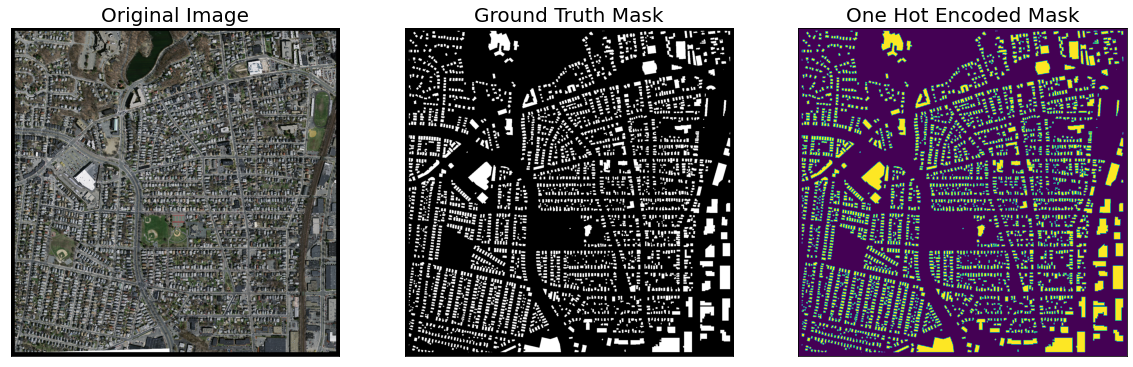

In [17]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [18]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [19]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

### Model Evaluation on Test Dataset

In [20]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")
print(f"FScore: {valid_logs['fscore']:.4f}")
print(f"Accuracy: {valid_logs['accuracy']:.4f}")
print(f"Recall: {valid_logs['recall']:.4f}")
print(f"Precision: {valid_logs['precision']:.4f}")

valid: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s, dice_loss - 0.09771, iou_score - 0.8293, fscore - 0.9062, accuracy - 0.908, recall - 0.9316, precision - 0.8821]
Evaluation on Test Data: 
Mean IoU Score: 0.8293
Mean Dice Loss: 0.0977
FScore: 0.9062
Accuracy: 0.9080
Recall: 0.9316
Precision: 0.8821


### Plot Dice Loss & IoU Metric for Train vs. Val

In [21]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5    \
dice_loss  0.533044  0.501855  0.472445  0.441691  0.408452  0.380597   
iou_score  0.246299  0.324521  0.401664  0.463721  0.549036  0.615197   
fscore     0.394870  0.488446  0.572623  0.632876  0.708529  0.761647   
accuracy   0.459804  0.534210  0.601405  0.652897  0.719592  0.767624   
recall     0.353044  0.446546  0.534417  0.598674  0.681907  0.742598   
precision  0.448972  0.541031  0.616824  0.671297  0.737391  0.781737   

                6         7         8         9    ...       140       141  \
dice_loss  0.365027  0.348068  0.327997  0.305721  ...  0.073884  0.069948   
iou_score  0.650944  0.683582  0.719097  0.756774  ...  0.871566  0.877569   
fscore     0.788220  0.811817  0.836239  0.861402  ...  0.931040  0.934529   
accuracy   0.790791  0.811888  0.834692  0.859233  ...  0.930818  0.934326   
recall     0.778641  0.811570  0.844067  0.874922  ...  0.933930  0.937380   
precision  0.798094  0.812134  0.828599  0.848347  ...  0.928169  0.931695   

                142       143       144       145       146       147  \
dice_loss  0.065995  0.061734  0.065117  0.062608  0.076849  0.067232   
iou_score  0.885819  0.892380  0.886214  0.890686  0.865762  0.882299   
fscore     0.938687  0.942824  0.939486  0.941811  0.927252  0.937196   
accuracy   0.938500  0.942649  0.939308  0.941640  0.927006  0.936995   
recall     0.941289  0.945536  0.942125  0.944424  0.930189  0.940024   
precision  0.936102  0.940128  0.936863  0.939213  0.924334  0.934387   

                148       149  
dice_loss  0.077053  0.064209  
iou_score  0.865365  0.887217  
fscore     0.927032  0.939893  
accuracy   0.926828  0.939703  
recall     0.929705  0.942717  
precision  0.924376  0.937086  

[6 rows x 150 columns]

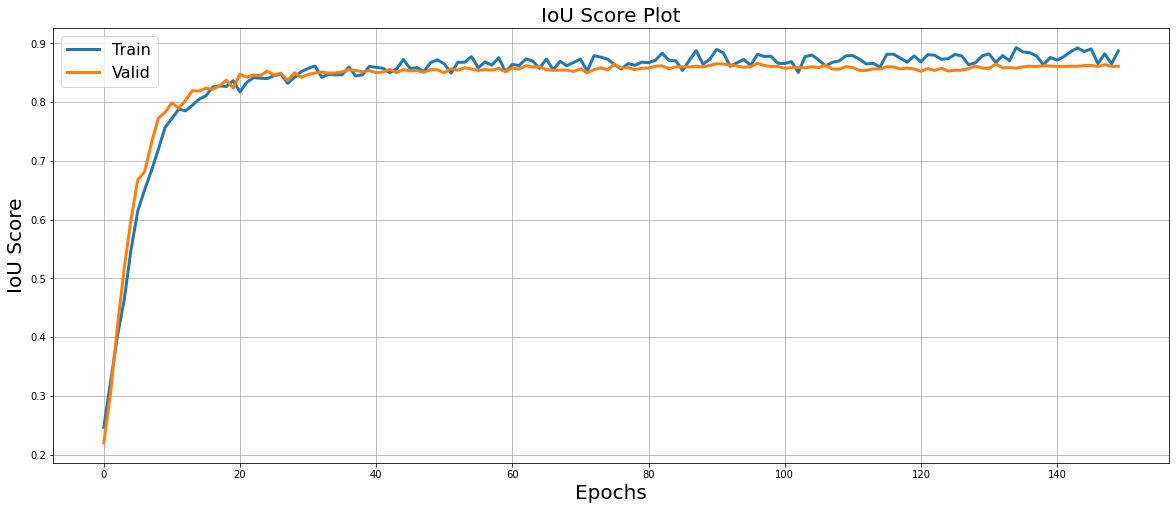

In [22]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

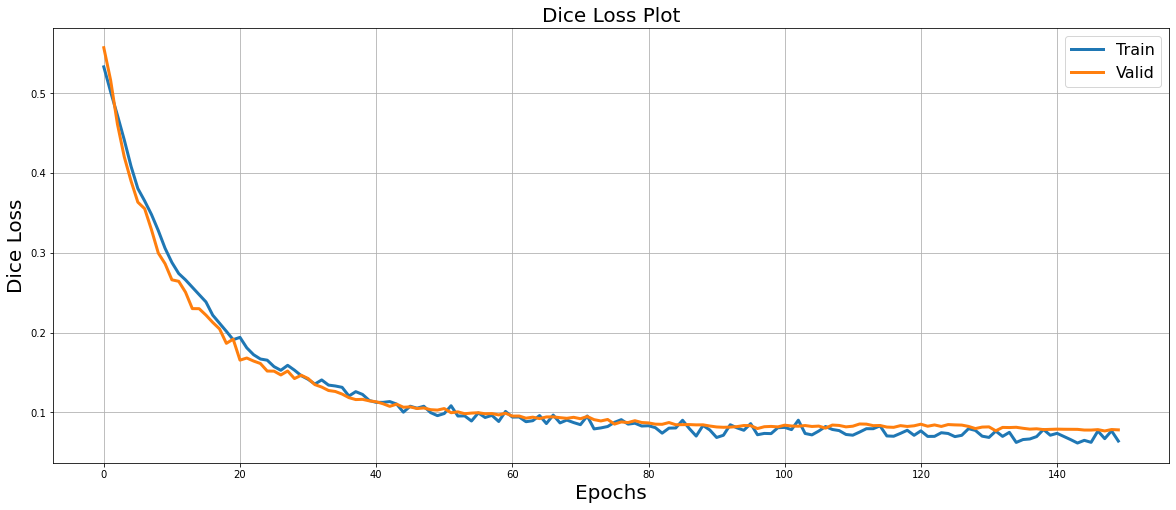

In [23]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

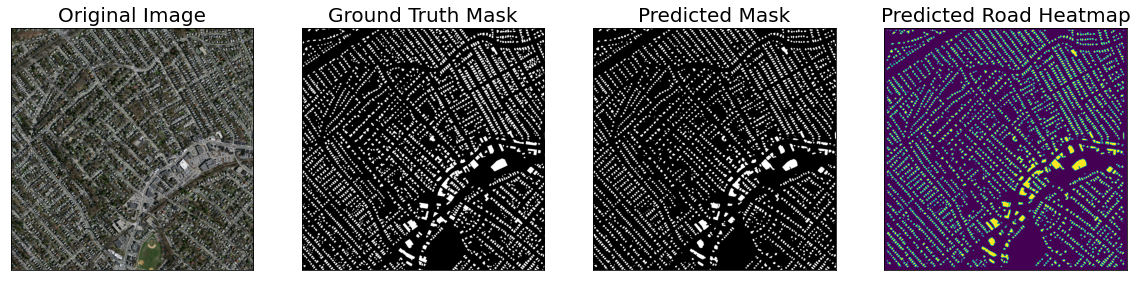

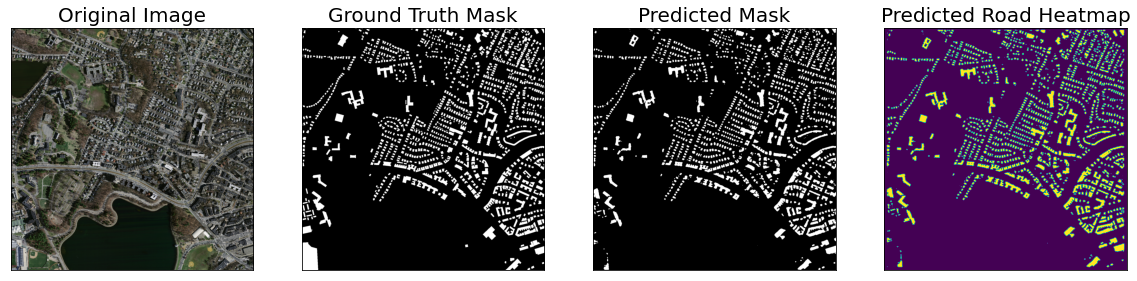

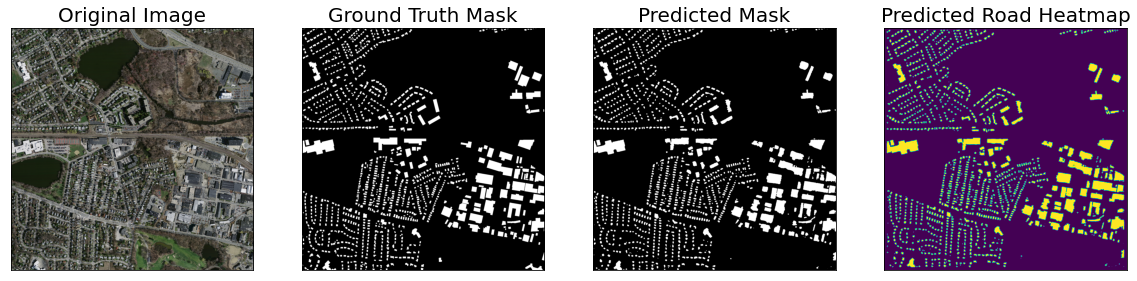

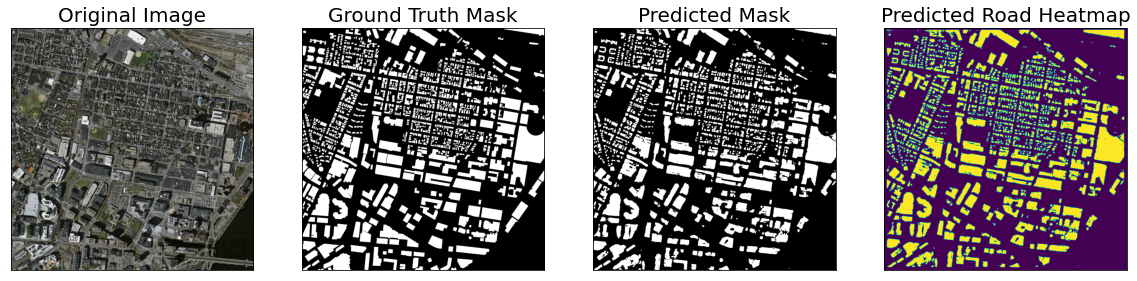

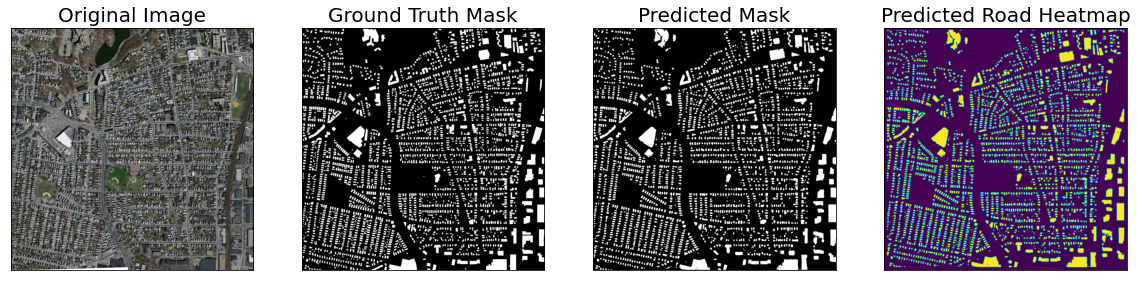

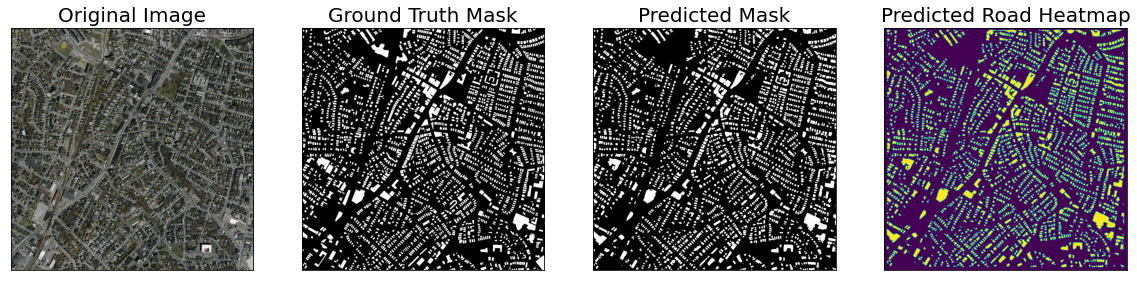

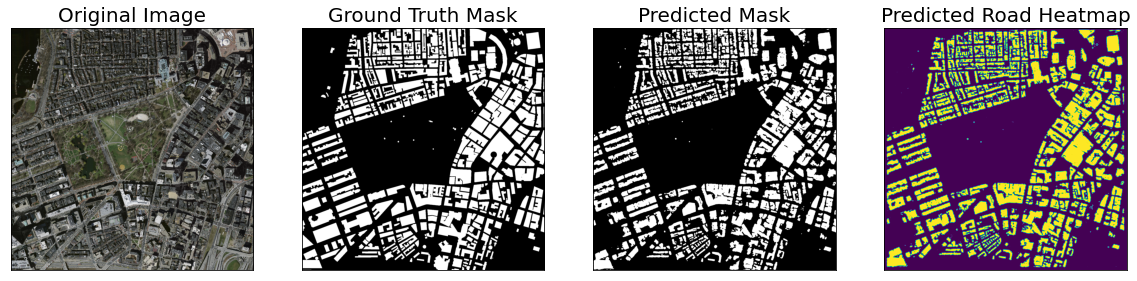

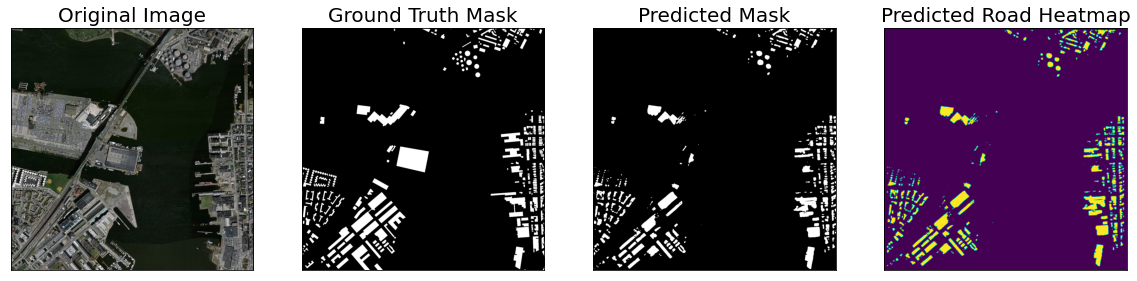

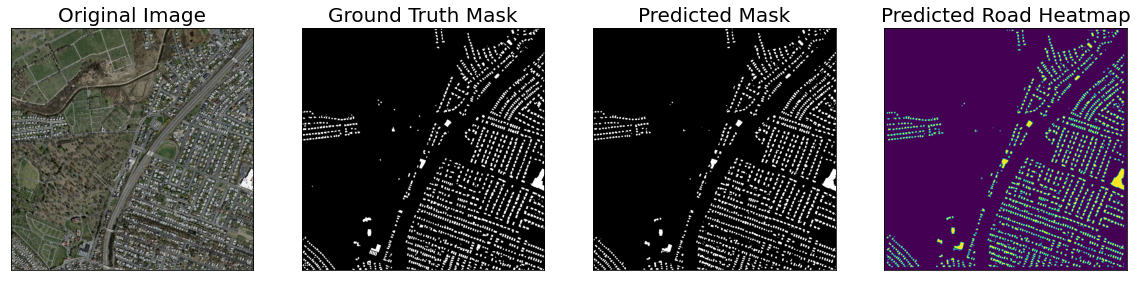

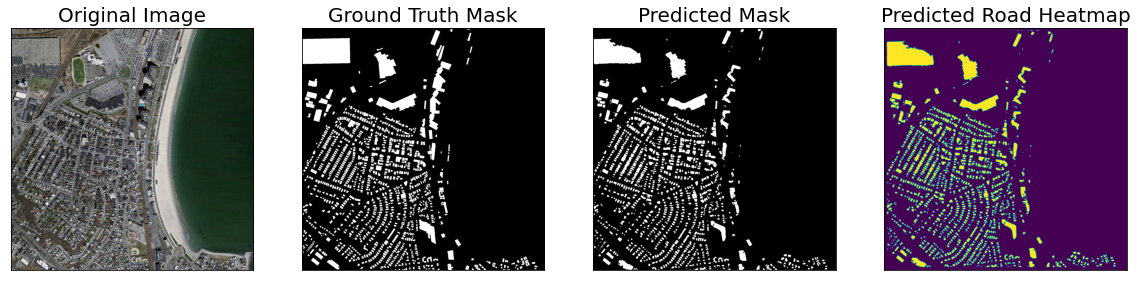

In [24]:
for idx in range(10):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )